In [1]:
import sys
import inspect

import pixiedust
from pylab import *

import pandas as pd
from pyquaternion import Quaternion 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

sys.path.append('..')
from Utilities import *

%matplotlib inline
np.random.seed=1

Pixiedust database opened successfully


In [4]:
path1 = '../datasets/30hz.csv'
dataset = pd.read_csv(path1)
length, width = dataset.shape

In [5]:
X, y = getXyAccelerationModel(dataset, limit=length)

train = int(0.9 * length)
xTrain, xTest, yTrain, yTest = X[:train], X[train:], y[:train], y[train:] 

In [6]:
X.head(5)

,dXB,dYB,dZB,dRoll,dPitch,dYaw,roll,pitch,moveForward,yawCCW,yawCW,hover
0,-2.221968e-08,-1.284391e-10,0.000019,2.411881e-15,-6.671646e-08,3.130743e-08,3.863957e-14,-1.208148e-09,0.0,0.0,0.0,1.0
1,-2.158101e-08,-1.284255e-10,-0.146831,2.481672e-15,-6.671646e-08,3.130743e-08,3.872494e-14,-3.609941e-09,0.0,0.0,0.0,1.0
2,-2.073219e-08,-1.284130e-10,-0.367945,2.545647e-15,-6.671646e-08,3.169877e-08,3.880302e-14,-5.811582e-09,0.0,0.0,0.0,1.0
3,-1.812264e-08,-1.283993e-10,-0.608522,2.527619e-15,6.671539e-08,3.600353e-08,3.888741e-14,-5.144442e-09,0.0,0.0,0.0,1.0
4,-1.503243e-08,-1.283856e-10,-0.847723,2.447361e-15,6.671539e-08,3.600353e-08,3.896480e-14,-2.942835e-09,0.0,0.0,0.0,1.0


## Sanity Check (Acceleration)

In [7]:
limit = 500
integration_error = np.zeros((limit, 6))

In [8]:
gen2 = integrateTrajectoryAccelerationBody(initialPosition=dataset.loc[1, ['x', 'y', 'z']].values,
                                           initialOrientation=dataset.loc[1, ['roll', 'pitch', 'yaw']].values,
                                           initialLinearVelocityBody=X.loc[0, ['dXB', 'dYB', 'dZB']].values,
                                           initialBodyRates=X.loc[0, ['dRoll', 'dPitch', 'dYaw']].values,
                                           
                                           linearAccelerationsBody=y[['d2XB', 'd2YB', 'd2ZB']].values,
                                           angularAccelerationsBody=y[['d2Roll', 'd2Pitch', 'd2Yaw']].values,
                                           frequency=10.0 * np.ones((limit, )))

figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')

for i in range(2, limit):
    p, o, _, _ = next(gen2)
    
    subplot(1, 2, 1)
    legend(['True'], fontsize=16)
    title('Trajectory: True', fontdict={'fontsize':20})
    
    pTrue = dataset.loc[i, ['x', 'y', 'z']]
    oTrue = dataset.loc[i, ['roll', 'pitch', 'yaw']]
    plt.scatter(pTrue[0], pTrue[1], color='green')
    
    subplot(1, 2, 2)
    legend(['Integrated'], fontsize=16)
    title('Trajectory: Integrated', fontdict={'fontsize':20})
    plt.scatter(p[0], p[1], color='red')
    
    integration_error[i - 2] = np.concatenate((p.astype(np.float64) - pTrue.astype(np.float64), 
                                               rad2deg(o.astype(np.float64) - oTrue.astype(np.float64))))
    
    try:
        assert(np.allclose(p.astype(np.float64), pTrue.astype(np.float64)))
        assert(np.allclose(o.astype(np.float64), oTrue.astype(np.float64)))
    except:
        pass

TypeError: 'NoneType' object is not an iterator

# Acceleration Prediction Models

### MLP Regressor (one step)

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

cvModel = MLPRegressor(max_iter=int(10e3), random_state=10)
parameters = {'hidden_layer_sizes':[(15, ), (25, )], 'alpha':[1e-6 * np.exp(i) for i in range(11)]}
clf = GridSearchCV(cvModel, parameters, n_jobs=-1).fit(xTrain, yTrain)

mlp_cv = MLPRegressor(hidden_layer_sizes=clf.best_params_['hidden_layer_sizes'],
                      alpha=clf.best_params_['alpha'], max_iter=int(10e8), random_state=10).fit(xTrain, yTrain)

In [7]:
yPredicted = pd.DataFrame(mlp_cv.predict(xTest), columns=y.columns)

print('MLP RMSE on test dataset:\n---')

for i in y.columns:
    print(i + '\t', mean_squared_error(yPredicted[i], yTest[i]) ** 0.5)
    
#mlp = MLPRegressor(hidden_layer_sizes=clf.best_params_['hidden_layer_sizes'],
#                    alpha=clf.best_params_['alpha'], max_iter=int(10e8), random_state=10).fit(X, y)

MLP RMSE on test dataset:
---
d2XB	 0.391401156099
d2YB	 0.24890034389
d2ZB	 0.514317056576
d2Roll	 0.279539224964
d2Pitch	 0.537647013862
d2Yaw	 0.418767233954


### Random Forest (one step)

In [9]:
from sklearn.ensemble import RandomForestRegressor

randomForest = RandomForestRegressor(max_depth=25, random_state=10).fit(xTrain, yTrain)

In [10]:
yPredicted2 = pd.DataFrame(randomForest.predict(xTest), columns=y.columns)

print('Random Forest RMSE on test dataset:\n---')

for i in y.columns:
    print(i + '\t', mean_squared_error(yPredicted2[i], yTest[i]) ** 0.5)

Random Forest RMSE on test dataset:
---
d2XB	 1.07680777309
d2YB	 1.36936188563
d2ZB	 0.45863247854
d2Roll	 6.49606735967
d2Pitch	 6.10971127129
d2Yaw	 0.57041285055


In [197]:
def predict(actions, initial, x0, frequency=10, limit=100, model=randomForest):
    initialPosition = initial[[0, 1, 2]]
    initialOrientation = initial[[3, 4, 5]]
    
    initialLinearVelocityBody = x0[[0, 1, 2]]
    initialAngularVelocityBody = x0[[3, 4, 5]]
    
    linear_velocities, angular_velocites = np.ones((limit, 3)), np.ones((limit, 3))
    
    for i in range(0, limit):
        if i > 0:
            s0 = np.concatenate((initialLinearVelocityBody, initialAngularVelocityBody, 
                                 initialOrientation[[0, 1]], actions[i]))
        else:
            s0 = x0
            
        s1 = model.predict(s0.reshape(1, -1))[0]
        
        initialPosition, initialOrientation, _, _ =\
        next(integrateTrajectoryAccelerationBody(initialPosition=initialPosition,
                                                 initialOrientation=initialOrientation,
                                                 
                                                 initialLinearVelocityBody = s0[[0, 1, 2]],
                                                 initialBodyRates = s0[[3, 4, 5]],
                                                 
                                                 linearAccelerationsBody=[s1[[0, 1, 2]]],
                                                 angularAccelerationsBody=[s1[[3, 4, 5]]],
                                        
                                                 frequency=[frequency]))
        
        yield initialPosition, initialOrientation

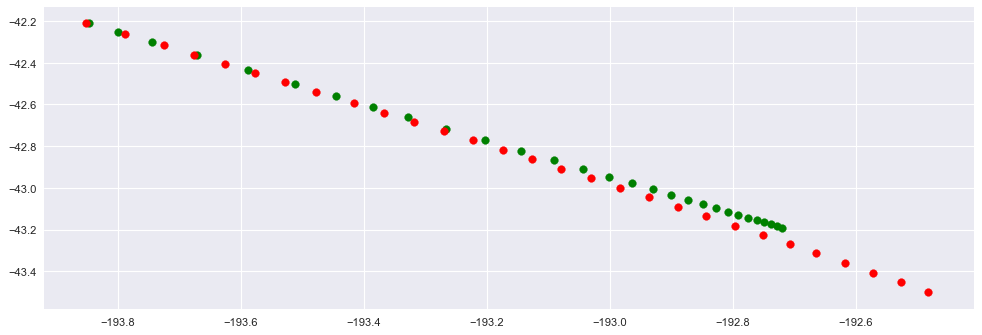

In [233]:
figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

limit = 30
shift = np.random.randint(xTest.shape[0]-limit)
prediction_error = np.zeros((limit, 6))

gen2 = predict(xTest[['moveForward', 'yawCCW', 'yawCW', 'hover']].values[shift:],
               dataset.loc[train+shift, ['x', 'y', 'z', 'roll', 'pitch', 'yaw']].values, xTest.iloc[shift].values, 10.0)


for i in range(1, limit):
    p, o = next(gen2)

    pTrue = dataset.loc[i+train+shift, ['x', 'y', 'z']]
    oTrue = dataset.loc[i+train+shift, ['roll', 'pitch', 'yaw']]
    plt.scatter(pTrue[0], pTrue[1], color='green')

    plt.scatter(p[0], p[1], color='red')
    
    prediction_error[i-1] = np.concatenate((p-pTrue, np.rad2deg(getAverageAngularVelocity(oTrue, o, 1.0))))

In [227]:
prediction_error_df = pd.DataFrame(prediction_error, columns=['x_error', 'y_error', 'z_error',
                                                              'psi_error', 'theta_error', 'phi_error'])


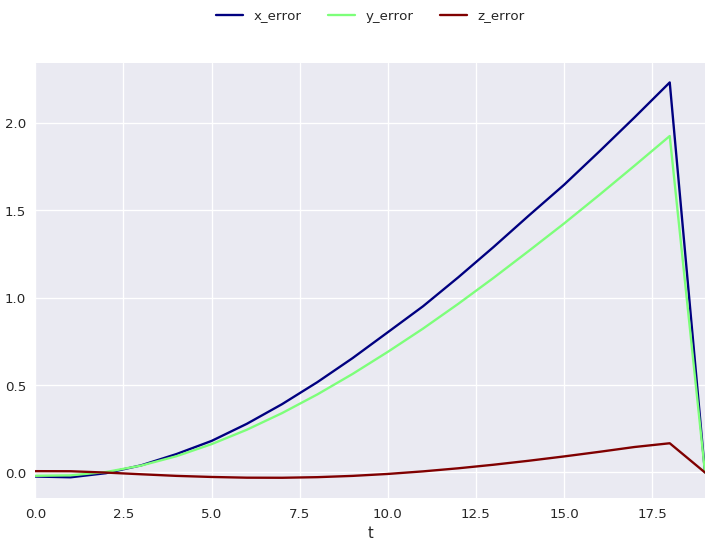

In [14]:
prediction_error_df['t'] = prediction_error_df.index
display(prediction_error_df)


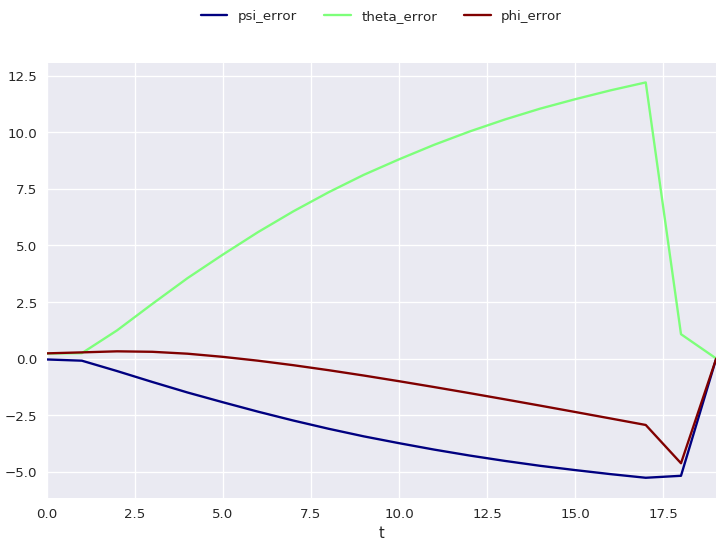

In [15]:
display(prediction_error_df)

In [16]:
joblib.dump(mlp, '../models/mlp.model')

NameError: name 'mlp' is not defined

In [11]:
import itertools

In [12]:
x = itertools.count(1)

In [14]:
next(x)

1

In [18]:
q1 = eulerToQuaternion(0, 0, np.pi/2)

In [19]:
q2 = eulerToQuaternion(0, 0, np.pi)

In [22]:
np.rad2deg(toEulerianAngle(q2 * q1.inverse))

array([  0.,   0.,  90.])